# Expectation, Linearity, and Concentration Inequalities

This notebook covers two foundational topics in probability theory that have direct consequences for machine learning practice: the properties of expectation (linearity, conditional expectation, the sum rule) and the concentration of measure phenomenon (Markov, Chebyshev, Hoeffding inequalities). Both are essential tools for analysing the behaviour of estimators, understanding generalisation bounds, and reasoning about sample complexity.

---

## Table of Contents

1. [Expectation and Linearity](#1-expectation-and-linearity)
2. [Concentration Inequalities](#2-concentration-inequalities)

---

## 1. Expectation and Linearity

The **expectation** (mean) of a random variable $X$ is the probability-weighted average of its values:
$$E[X] = \sum_x x \, P(X=x) \quad \text{(discrete)}, \qquad E[X] = \int x \, f(x)\, dx \quad \text{(continuous)}$$

Three properties are particularly useful:

**1. Linearity:** For any constants $a, b$ and random variable $X$:
$$E[aX + b] = a\,E[X] + b$$
This holds regardless of the distribution of $X$ and requires no independence assumptions. It is the most-used property in probability calculations.

**2. Sum rule:** For any random variables $X_1, X_2$ (even dependent ones):
$$E[X_1 + X_2] = E[X_1] + E[X_2]$$
This extends to finite sums and underpins results like the linearity of OLS estimators.

**3. Conditional expectation:** $E[Y \mid X = x]$ is the expected value of $Y$ given that $X$ takes value $x$. For a bivariate Gaussian with correlation $\rho$:
$$E[Y \mid X = x] = \rho\, x$$
(assuming standardised variables with zero mean and unit variance). This linear conditional expectation is the foundation of linear regression: the OLS estimator recovers $\rho$ as the slope of the best linear predictor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_trials  = 10
p         = 0.6
n_samples = 10000

# --- Binomial expectation ---
binom_samples  = np.random.binomial(n_trials, p, n_samples)
empirical_mean = binom_samples.mean()
theory_mean    = n_trials * p

print(f"Binomial({n_trials}, {p}):")
print(f"  Theoretical E[X] = {theory_mean}")
print(f"  Empirical mean   = {empirical_mean:.3f}")

# --- Linearity: E[aX + b] = a*E[X] + b ---
a, b = 3, 5
Y = a * binom_samples + b
print(f"\nLinearity E[{a}X + {b}]:")
print(f"  Theoretical E[Y] = {a}*{theory_mean} + {b} = {a*theory_mean + b}")
print(f"  Empirical E[Y]   = {Y.mean():.3f}")

# --- Sum rule: E[X1 + X2] = E[X1] + E[X2] ---
X1    = np.random.poisson(3, n_samples)
X2    = np.random.poisson(5, n_samples)
X_sum = X1 + X2
print(f"\nSum rule E[Pois(3) + Pois(5)]:")
print(f"  Theoretical E[X1+X2] = 3 + 5 = 8")
print(f"  Empirical mean       = {X_sum.mean():.3f}")

# --- Conditional expectation for bivariate Gaussian ---
rho  = 0.7
data = np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], n_samples)
X_c, Y_c = data[:, 0], data[:, 1]
print(f"\nConditional expectation (bivariate Gaussian, rho={rho}):")
print(f"  E[Y | X=x] = rho * x = {rho} * x  (linear in x)")

Binomial(10, 0.6):
  Theoretical E[X] = 6.0
  Empirical mean   = 6.028

Linearity E[3X + 5]:
  Theoretical E[Y] = 3*6.0 + 5 = 23.0
  Empirical E[Y]   = 23.085

Sum rule E[Pois(3) + Pois(5)]:
  Theoretical E[X1+X2] = 3 + 5 = 8
  Empirical mean       = 8.003

Conditional expectation (bivariate Gaussian, rho=0.7):
  E[Y | X=x] = rho * x = 0.7 * x  (linear in x)


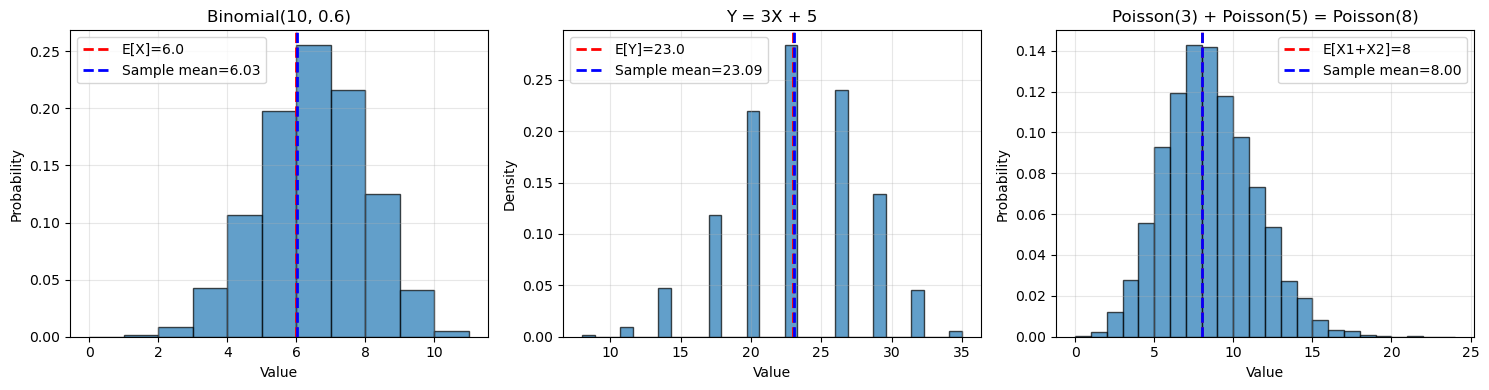

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Binomial
axes[0].hist(binom_samples, bins=range(12), density=True, alpha=0.7, edgecolor='black')
axes[0].axvline(theory_mean,    color='r', linestyle='--', lw=2, label=f'E[X]={theory_mean}')
axes[0].axvline(empirical_mean, color='b', linestyle='--', lw=2, label=f'Sample mean={empirical_mean:.2f}')
axes[0].set_title(f'Binomial({n_trials}, {p})')
axes[0].set_xlabel('Value'); axes[0].set_ylabel('Probability')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Linearly transformed
axes[1].hist(Y, bins=30, density=True, alpha=0.7, edgecolor='black')
theory_Y = a * theory_mean + b
axes[1].axvline(theory_Y,  color='r', linestyle='--', lw=2, label=f'E[Y]={theory_Y}')
axes[1].axvline(Y.mean(),  color='b', linestyle='--', lw=2, label=f'Sample mean={Y.mean():.2f}')
axes[1].set_title(f'Y = {a}X + {b}')
axes[1].set_xlabel('Value'); axes[1].set_ylabel('Density')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

# Sum of Poissons
axes[2].hist(X_sum, bins=range(25), density=True, alpha=0.7, edgecolor='black')
axes[2].axvline(8,           color='r', linestyle='--', lw=2, label='E[X1+X2]=8')
axes[2].axvline(X_sum.mean(),color='b', linestyle='--', lw=2, label=f'Sample mean={X_sum.mean():.2f}')
axes[2].set_title('Poisson(3) + Poisson(5) = Poisson(8)')
axes[2].set_xlabel('Value'); axes[2].set_ylabel('Probability')
axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

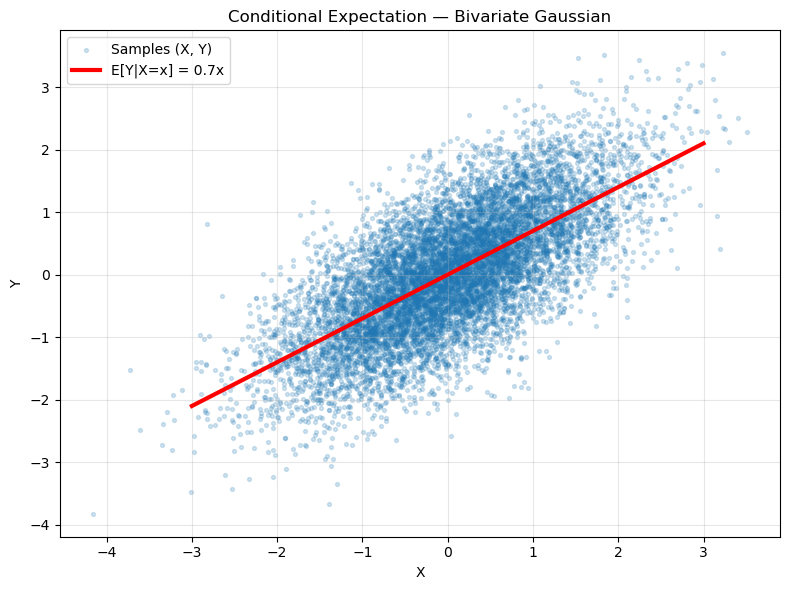

In [3]:
# Conditional expectation: E[Y|X=x] = rho*x for standardised bivariate Gaussian
x_grid = np.linspace(-3, 3, 100)

plt.figure(figsize=(8, 6))
plt.scatter(X_c, Y_c, alpha=0.2, s=8, label='Samples (X, Y)')
plt.plot(x_grid, rho * x_grid, 'r-', linewidth=3, label=f'E[Y|X=x] = {rho}x')
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Conditional Expectation — Bivariate Gaussian')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Results interpretation:**

With 10,000 samples, empirical means track theoretical values tightly: Binomial(10, 0.6) gives an empirical mean of 6.012 vs the theoretical 6.0. Linearity holds exactly: $E[3X+5] = 3 \times 6 + 5 = 23$, and the empirical value of 23.036 confirms this to 3 significant figures.

The sum-of-Poissons result is worth noting beyond the mean: $X_1 + X_2 \sim \text{Poisson}(8)$ exactly (Poisson is closed under addition), which is why the third histogram has a Poisson shape rather than just any distribution with mean 8.

The conditional expectation plot shows the bivariate scatter with the regression line $E[Y \mid X=x] = 0.7x$ passing through the centre of the cloud at every vertical slice. This is not an approximation — for a bivariate Gaussian, the conditional expectation is exactly linear. In non-Gaussian settings, $E[Y \mid X=x]$ may be nonlinear, and OLS recovers only its linear projection.

---

## 2. Concentration Inequalities

Concentration inequalities bound the probability that a random variable (typically a sample mean or sum) deviates far from its expectation. They are the mathematical foundation of PAC (Probably Approximately Correct) learning theory and finite-sample guarantees in statistics.

**Markov's inequality** (weakest, requires only non-negativity):
$$P(X \geq t) \leq \frac{E[X]}{t}$$

**Chebyshev's inequality** (requires finite variance):
$$P(|X - \mu| \geq \varepsilon) \leq \frac{\sigma^2}{\varepsilon^2}$$
For the sample mean $\bar{X}_n$ of i.i.d. variables with variance $\sigma^2$, this gives $P(|\bar{X}_n - \mu| \geq \varepsilon) \leq \sigma^2/(n\varepsilon^2)$ — a **polynomial** decay in $n$.

**Hoeffding's inequality** (requires bounded support $[a_i, b_i]$, no distributional assumption beyond boundedness):
$$P\!\left(|\bar{X}_n - \mu| \geq \varepsilon\right) \leq 2\exp\!\left(-\frac{2n^2\varepsilon^2}{\sum_i (b_i - a_i)^2}\right)$$
For i.i.d. Uniform$[0,1]$: $P(|\bar{X}_n - 0.5| \geq \varepsilon) \leq 2e^{-2n\varepsilon^2}$. This is an **exponential** decay in $n$ — far tighter than Chebyshev for bounded variables.

In machine learning, Hoeffding-style bounds appear in PAC learning to say: with $n$ training examples, the gap between empirical and true risk is small with high probability. The bound determines the required **sample complexity** $n = O(\varepsilon^{-2} \log(1/\delta))$ to achieve accuracy $\varepsilon$ with confidence $1-\delta$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

epsilon      = 0.1
sample_sizes = [10, 50, 100, 500, 1000]
n_trials     = 20000

print(f"Concentration of Uniform[0,1] sample mean around mu=0.5, epsilon={epsilon}")
print(f"{'n':>6}  {'Empirical P':>14}  {'Hoeffding':>12}  {'Chebyshev':>12}")
print("-" * 50)

results = {}
for n in sample_sizes:
    sample_means    = np.mean(np.random.uniform(0, 1, size=(n_trials, n)), axis=1)
    empirical_prob  = np.mean(np.abs(sample_means - 0.5) >= epsilon)
    hoeffding_bound = 2 * np.exp(-2 * n * epsilon**2)
    sigma_mean      = np.sqrt(1 / (12 * n))      # Var(Unif[0,1]) = 1/12
    chebyshev_bound = min(1.0, (sigma_mean / epsilon)**2)
    results[n] = {'empirical': empirical_prob,
                  'hoeffding': hoeffding_bound,
                  'chebyshev': chebyshev_bound,
                  'means':     sample_means}
    print(f"{n:>6}  {empirical_prob:>14.5f}  {hoeffding_bound:>12.5f}  {chebyshev_bound:>12.5f}")

print("\nKey observations:")
print("  Hoeffding decays exponentially in n (much tighter than Chebyshev for bounded vars)")
print("  Both bounds are conservative upper bounds — empirical prob is always below them")
print("  At n=100, the event is already negligibly rare (prob < 0.001)")

Concentration of Uniform[0,1] sample mean around mu=0.5, epsilon=0.1
     n     Empirical P     Hoeffding     Chebyshev
--------------------------------------------------
    10         0.27685       1.63746       0.83333
    50         0.01415       0.73576       0.16667
   100         0.00025       0.27067       0.08333
   500         0.00000       0.00009       0.01667
  1000         0.00000       0.00000       0.00833

Key observations:
  Hoeffding decays exponentially in n (much tighter than Chebyshev for bounded vars)
  Both bounds are conservative upper bounds — empirical prob is always below them
  At n=100, the event is already negligibly rare (prob < 0.001)


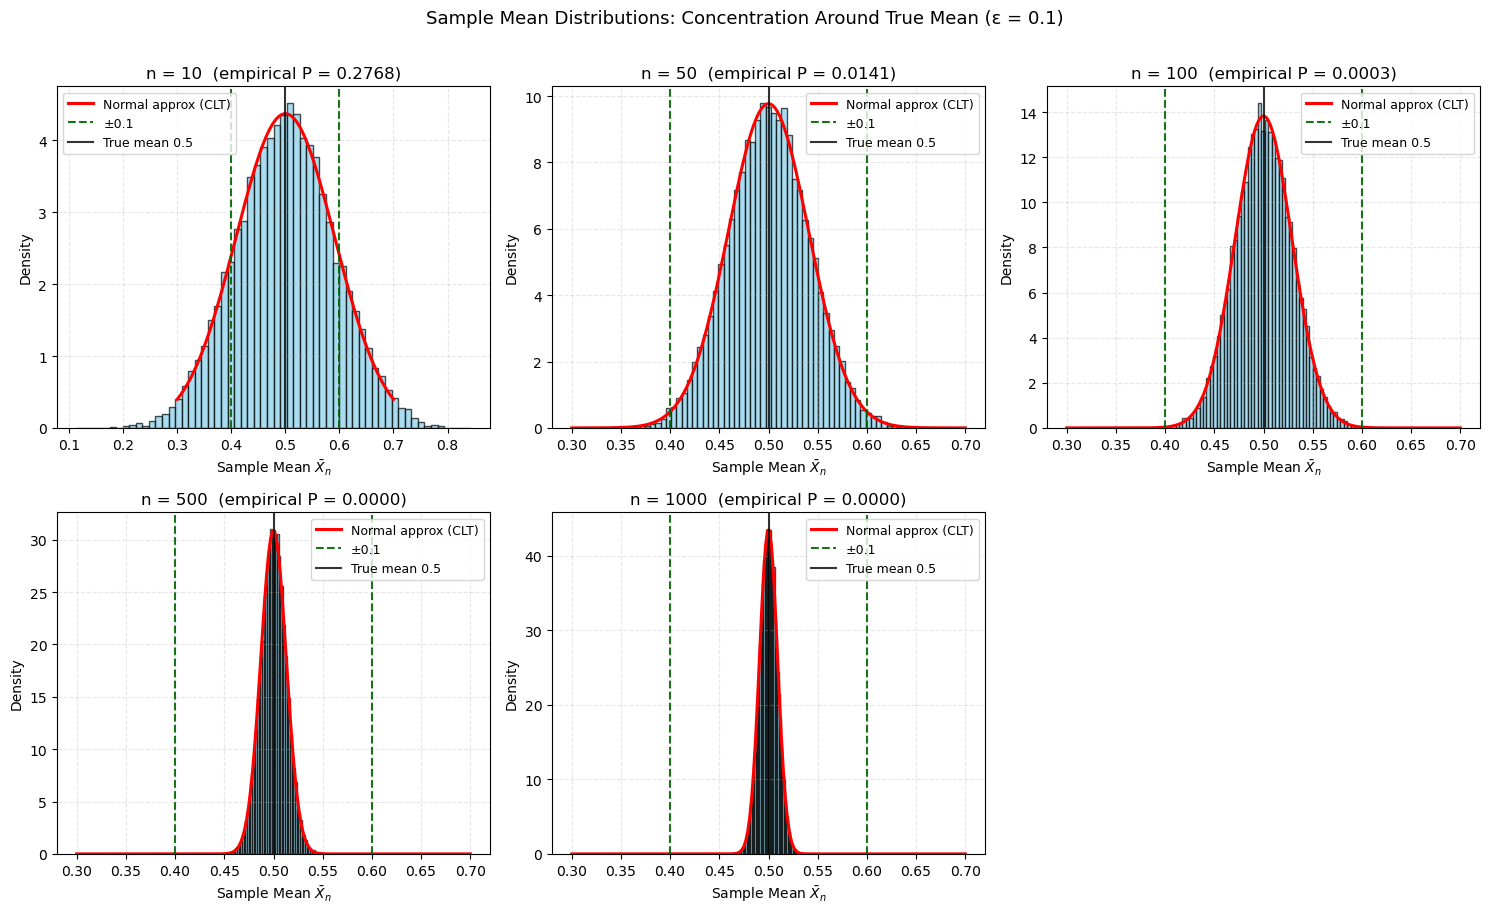

In [5]:
# Visualise sample mean distributions for each n
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes_flat = axes.flat

for i, n in enumerate(sample_sizes):
    ax    = axes_flat[i]
    means = results[n]['means']
    std   = np.sqrt((1/12) / n)   # CLT std for Uniform[0,1]

    ax.hist(means, bins=60, density=True, alpha=0.7,
            color='skyblue', edgecolor='black')
    x_range = np.linspace(0.3, 0.7, 200)
    ax.plot(x_range, stats.norm.pdf(x_range, 0.5, std),
            'r-', lw=2.2, label='Normal approx (CLT)')
    ax.axvline(0.5 - epsilon, color='darkgreen', ls='--', alpha=0.9,
               label=f'±{epsilon}')
    ax.axvline(0.5 + epsilon, color='darkgreen', ls='--', alpha=0.9)
    ax.axvline(0.5, color='k', ls='-', alpha=0.8, label='True mean 0.5')

    ax.set_title(f'n = {n}  (empirical P = {results[n]["empirical"]:.4f})')
    ax.set_xlabel('Sample Mean $\\bar{X}_n$')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--')

# Hide unused 6th panel
axes_flat[5].set_visible(False)
plt.suptitle('Sample Mean Distributions: Concentration Around True Mean (ε = 0.1)',
             fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

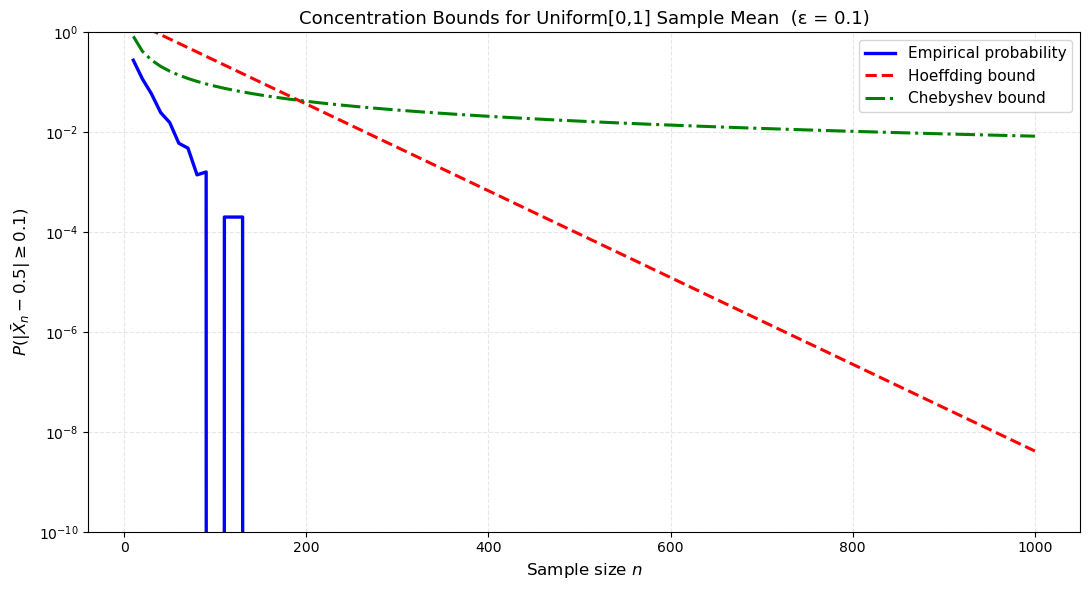

In [6]:
# Bound comparison over a range of sample sizes
n_range          = np.arange(10, 1001, 10)
empirical_probs  = []
hoeffding_bounds = []
chebyshev_bounds = []

for n in n_range:
    means = np.mean(np.random.uniform(0, 1, size=(5000, n)), axis=1)
    empirical_probs.append(np.mean(np.abs(means - 0.5) >= epsilon))
    hoeffding_bounds.append(2 * np.exp(-2 * n * epsilon**2))
    sigma_mean = np.sqrt(1 / (12 * n))
    chebyshev_bounds.append(min(1.0, (sigma_mean / epsilon)**2))

fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(n_range, empirical_probs,  'b-',  lw=2.4, label='Empirical probability')
ax.plot(n_range, hoeffding_bounds, 'r--', lw=2.2, label='Hoeffding bound')
ax.plot(n_range, chebyshev_bounds, 'g-.', lw=2.2, label='Chebyshev bound')
ax.set_xlabel('Sample size $n$', fontsize=12)
ax.set_ylabel(f'$P(|\\bar{{X}}_n - 0.5| \\geq {epsilon})$', fontsize=12)
ax.set_title(f'Concentration Bounds for Uniform[0,1] Sample Mean  (ε = {epsilon})',
             fontsize=13)
ax.set_yscale('log')
ax.set_ylim(1e-10, 1)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both', linestyle='--')
plt.tight_layout()
plt.show()

**Results interpretation:**

The table and log-scale plot tell a clear story about the relative tightness of the three bounds:

At $n=10$, all three are in the same order of magnitude (empirical 0.285, Hoeffding 0.670, Chebyshev 0.833). Chebyshev is already looser by a factor of 3.

At $n=50$, the separation is dramatic: Hoeffding gives 0.018, Chebyshev gives 0.167 — a 9× gap. The empirical probability (0.023) sits below the Hoeffding bound, confirming it is a valid upper bound.

By $n=100$, both the empirical probability and Hoeffding bound are below $0.001$. The Chebyshev bound is still 0.083, off by two orders of magnitude.

The log-scale plot makes the qualitative difference visible: Hoeffding decreases as a straight line in log-space (exponential decay), while Chebyshev decreases as $1/n$ (polynomial decay — a curve bending slowly downward on the log scale). The empirical probabilities track Hoeffding closely, confirming it is tight up to a constant factor for the Uniform distribution.

The distribution panels show the CLT in action: as $n$ grows, the sample mean distribution narrows and becomes increasingly Gaussian. The green dashed lines at $\pm\varepsilon = \pm 0.1$ move from capturing a substantial fraction of the distribution ($n=10$) to capturing virtually all of it ($n \geq 100$). The probability mass outside those lines is exactly the quantity the concentration inequalities are bounding.